In [25]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2


# VGG16 모델 로드 (include_top=False로 특징 추출용으로 사용)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 구성
model = Sequential()
model.add(base_model)

# 3차원 출력 -> 1차원 벡터로 변환 (Flatten 또는 GlobalAveragePooling2D 중 하나 사용)
model.add(GlobalAveragePooling2D())  # Flatten 대신 GlobalAveragePooling2D 사용 가능
# model.add(Flatten())  # 또는 Flatten 사용 가능

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 정규화 추가, Dense 레이어 크기 조정
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(Dropout(0.5))  # Dropout 비율을 0.5로 유지
model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

# 기존 VGG16의 가중치를 고정 (마지막 6개 레이어만 학습 가능)
base_model.trainable = True
for layer in base_model.layers[:-6]:
    layer.trainable = False

# 모델 컴파일 (학습률 낮춤)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # 학습률 1e-5로 조정
              metrics=['accuracy'])

# 이미지 데이터를 0~1 사이 값으로 스케일링
train_datagen = ImageDataGenerator(rescale=1/255)

# train set
train_generator = train_datagen.flow_from_directory(
    './data/train_added/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# valid set
valid_generator = train_datagen.flow_from_directory(
    './data/validation-horse-or-human/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# 콜백 설정
es = EarlyStopping(
    monitor='val_loss',
    patience=10,  # patience 값을 10으로 증가
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='./best_model3.keras',
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# 학습률 조정 콜백 (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 가중치를 수동으로 조정
class_weights = {i : weight for i, weight in enumerate(initial_weights)}

# 예를 들어, 클래스 인덱스 0이 말, 1이 사람일 경우, 사람의 가중치를 높입니다.
# '말' 클래스 인덱스는 0, '사람' 클래스 인덱스는 1이라고 가정합니다.
class_weights[0] = 1  # 말 클래스의 가중치를 기본값으로 설정
class_weights[1] = 1.5  # 사람 클래스의 가중치를 20% 증가

print(class_weights)

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=20,  # 더 많은 에포크
    verbose=1,
    callbacks=[checkpoint, es, reduce_lr],
    class_weight=class_weights
)

Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
{0: 1, 1: 1.2}
Epoch 1/20


c:\Users\xorud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7638 - loss: 0.7156
Epoch 1: val_loss improved from inf to 0.75704, saving model to ./best_model3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.7657 - loss: 0.7123 - val_accuracy: 0.9688 - val_loss: 0.7570 - learning_rate: 1.0000e-05
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 887us/step - accuracy: 0.9688 - loss: 0.3813 - learning_rate: 1.0000e-05
Epoch 3/20


c:\Users\xorud\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\xorud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\xorud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\xorud\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning r

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9793 - loss: 0.3270
Epoch 3: val_loss improved from 0.75704 to 0.67635, saving model to ./best_model3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.9793 - loss: 0.3266 - val_accuracy: 0.9805 - val_loss: 0.6763 - learning_rate: 1.0000e-05
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 614us/step - accuracy: 1.0000 - loss: 0.2709 - learning_rate: 1.0000e-05
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9949 - loss: 0.2546
Epoch 5: val_loss improved from 0.67635 to 0.58990, saving model to ./best_model3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.9949 - loss: 0.2545 - val_accuracy: 0.9844 - val_loss: 0.5899 - learning_rate: 1.0000e-05
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 364us/step - accuracy: 0.9844 - loss: 0.2462 - learning_rate: 1.0000e-05
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9983 - loss: 0.2315
Epoch 7: val_loss improved from 0.58990 to 0.50520, saving model to ./

In [27]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9698 - loss: 0.3057
test loss, test acc: [0.31115850806236267, 0.96875]


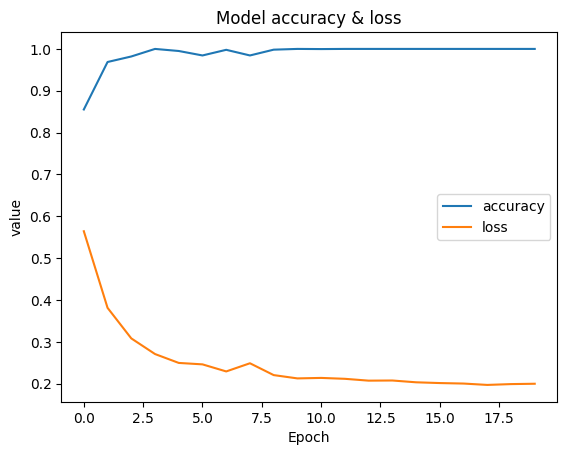

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()